In [110]:
import numpy
import re
import string
from urllib.request import urlopen
import scipy.optimize
from sklearn.decomposition import PCA
import random
from math import exp
from math import log
import matplotlib.pyplot as plt
from collections import Counter

In [111]:
def parseData(fname):
  for l in urlopen(fname):
    yield eval(l)

In [112]:
print("Reading data...")
data = list(parseData("http://jmcauley.ucsd.edu/cse190/data/beer/beer_50000.json"))
print("done")

Reading data...
done


In [114]:
def feature(datum):
  feat = [1, datum['review/taste'], datum['review/appearance'], datum['review/aroma'], datum['review/palate'], datum['review/overall']]
  return feat

In [115]:
X = [feature(d) for d in data]
y = [d['beer/ABV'] >= 6.5 for d in data]
print(data[0])
temp = data[0]['review/text']
#occurrence = Counter(temp.translate(string.punctuation).split())
#print(occurrence)
print(temp)
print(string.punctuation)
#count = sum(1 for _ in re.finditer(r'\b%s\b' % re.escape('a'), temp))
temp = re.sub('['+string.punctuation+']', '', temp)
print(temp)
w = temp.split()
c = Counter(w)

print(c['foam'])

{'review/appearance': 2.5, 'beer/style': 'Hefeweizen', 'review/palate': 1.5, 'review/taste': 1.5, 'beer/name': 'Sausa Weizen', 'review/timeUnix': 1234817823, 'beer/ABV': 5.0, 'beer/beerId': '47986', 'beer/brewerId': '10325', 'review/timeStruct': {'isdst': 0, 'mday': 16, 'hour': 20, 'min': 57, 'sec': 3, 'mon': 2, 'year': 2009, 'yday': 47, 'wday': 0}, 'review/overall': 1.5, 'review/text': 'A lot of foam. But a lot.\tIn the smell some banana, and then lactic and tart. Not a good start.\tQuite dark orange in color, with a lively carbonation (now visible, under the foam).\tAgain tending to lactic sourness.\tSame for the taste. With some yeast and banana.', 'user/profileName': 'stcules', 'review/aroma': 2.0}
A lot of foam. But a lot.	In the smell some banana, and then lactic and tart. Not a good start.	Quite dark orange in color, with a lively carbonation (now visible, under the foam).	Again tending to lactic sourness.	Same for the taste. With some yeast and banana.
!"#$%&'()*+,-./:;<=>?@[\]

In [116]:
def inner(x,y):
  return sum([x[i]*y[i] for i in range(len(x))])

def sigmoid(x):
  return 1.0 / (1 + exp(-x))

In [117]:
##################################################
# Logistic regression by gradient ascent         #
##################################################

In [118]:
# NEGATIVE Log-likelihood
def f(theta, X, y, lam):
  loglikelihood = 0
  for i in range(len(X)):
    logit = inner(X[i], theta)
    loglikelihood -= log(1 + exp(-logit))
    if not y[i]:
      loglikelihood -= logit
  for k in range(len(theta)):
    loglikelihood -= lam * theta[k]*theta[k]
  # for debugging
  # print("ll =" + str(loglikelihood))
  return -loglikelihood

In [119]:
# NEGATIVE Derivative of log-likelihood
def fprime(theta, X, y, lam):
  dl = [0]*len(theta)
  for i in range(len(X)):
    logit = inner(X[i], theta)
    for k in range(len(theta)):
      dl[k] += X[i][k] * (1 - sigmoid(logit))
      if not y[i]:
        dl[k] -= X[i][k]
  for k in range(len(theta)):
    dl[k] -= lam*2*theta[k]
  return numpy.array([-x for x in dl])

In [120]:
X_train, X_validation, X_test = numpy.array_split(X, 3)
y_train, y_validation, y_test = numpy.array_split(y, 3)
print(len(X_train))
print(len(X_test))
print(len(X_validation))

16667
16666
16667


In [121]:
##################################################
# Train                                          #
##################################################
print(X_test[0])
print(y_test[0])

[ 1.  5.  5.  5.  5.  5.]
True


In [122]:
def train(lam):
  theta,_,_ = scipy.optimize.fmin_l_bfgs_b(f, [0]*len(X[0]), fprime, pgtol = 10, args = (X_train, y_train, lam))
  return theta

In [123]:
##################################################
# Predict                                        #
##################################################

In [124]:
def performance(theta, X, Y):
  scores = [inner(theta,x) for x in X]
  predictions = [s > 0 for s in scores]
  correct = [(a==b) for (a,b) in zip(predictions,Y)]
  acc = sum(correct) * 1.0 / len(correct)
  return acc

In [125]:
##################################################
# Validation pipeline                            #
##################################################

In [126]:
lam = 1.0

theta = train(lam)
acc_train = performance(theta, X_train, y_train)
print("lambda = " + str(lam) + ":\ttrain accuracy=" + str(acc_train))
acc_validation = performance(theta, X_validation, y_validation)
print("lambda = " + str(lam) + ":\tvalidation accuracy=" + str(acc_validation))
acc_test = performance(theta, X_test, y_test)
print("lambda = " + str(lam) + ":\ttest accuracy=" + str(acc_test))

lambda = 1.0:	train accuracy=0.669946601068
lambda = 1.0:	validation accuracy=0.90076198476
lambda = 1.0:	test accuracy=0.577163086523


In [127]:
def feature1(datum):
  rev = datum['review/text'].lower()
  rev = re.sub('['+string.punctuation+']', '', rev)
  w = rev.split()
  c = Counter(w)
  #temp = re.sub(r'[^\w\s]','',rev)
  feat = [1, c['lactic'], 
          c['tart'], 
          c['sour'], 
          c['citric'], 
          c['sweet'], 
          c['acid'], 
          c['hop'],
         c['fruit'], 
          c['salt'], 
          c['spicy']]
  return feat

In [128]:
X = [feature1(d) for d in data]
X_train, X_validation, X_test = numpy.array_split(X, 3)

lam = 1.0

theta = train(lam)
acc_train = performance(theta, X_train, y_train)
print("lambda = " + str(lam) + ":\ttrain accuracy=" + str(acc_train))
acc_validation = performance(theta, X_validation, y_validation)
print("lambda = " + str(lam) + ":\tvalidation accuracy=" + str(acc_validation))
acc_test = performance(theta, X_test, y_test)
print("lambda = " + str(lam) + ":\ttest accuracy=" + str(acc_test))


lambda = 1.0:	train accuracy=0.562608747825
lambda = 1.0:	validation accuracy=0.946301073979
lambda = 1.0:	test accuracy=0.36229449178


In [129]:
def performance_detailed(theta, X, Y):
  scores = [inner(theta,x) for x in X]
  predictions = [s > 0 for s in scores]
  TP = sum([(a==b) and a==True for (a,b) in zip(predictions,Y)])
  TN = sum([(a==b) and a==False for (a,b) in zip(predictions, Y)])
  FP = sum([(a!=b) and a==True for (a,b) in zip(predictions, Y)])
  FN = sum([(a!=b) and a==False for (a,b) in zip(predictions, Y)])
  TPR = TP/(TP+FN)
  TNR = TN/(TN+FP)
  BER = 1 - 0.5*(TPR+TNR)
  print("Balanced Error Rate: " + str(BER))
  print("True +ve: " + str(TP))
  print("True -ve: " + str(TN))
  print("False +ve: " + str(FP))
  print("False -ve: " + str(FN))
  print("Total: " + str(len(predictions)))
  print("Sanity check: " + str(TP+TN+FP+FN))

In [131]:
performance_detailed(theta, X_test, y_test)

Balanced Error Rate: 0.497105515479
True +ve: 5832
True -ve: 206
False +ve: 10549
False -ve: 79
Total: 16666
Sanity check: 16666


In [132]:
# NEGATIVE Log-likelihood for class imbalance
def fc(theta, X, y, lam):
  total = len(y)
  y1count = sum(y)
  y0count = total - sum(y)
  y1balance = total/(2*y1count)
  y0balance = total/(2*y0count)
  #print("Y1, Y0 : " +str(y1count)+","+str(y0count))
  loglikelihood = 0
  for i in range(len(X)):
    logit = inner(X[i], theta)
    if(y[i]):
        loglikelihood -= (y1balance*log(1+exp(-logit)))
    elif not y[i]:
        loglikelihood -= (y0balance*(logit + log(1+exp(-logit))))
  for k in range(len(theta)):
    loglikelihood -= lam * theta[k]*theta[k]
  # for debugging
  # print("ll =" + str(loglikelihood))
  return -loglikelihood

In [133]:
# NEGATIVE Derivative of log-likelihood for class imbalance
def fcprime(theta, X, y, lam):
  total = len(y)
  y1count = sum(y)
  y0count = total - sum(y)
  y1balance = total/(2*y1count)
  y0balance = total/(2*y0count)
  dl = [0]*len(theta)
  for i in range(len(X)):
    logit = inner(X[i], theta)
    for k in range(len(theta)):
      if y[i]:
        dl[k] += (y1balance*(X[i][k] * (1-sigmoid(logit))))
      elif not y[i]:
        dl[k] -= (y0balance*(X[i][k]*sigmoid(logit)))
  for k in range(len(theta)):
    dl[k] -= lam*2*theta[k]
  return numpy.array([-x for x in dl])

In [134]:
def trainc(lam):
  theta,_,_ = scipy.optimize.fmin_l_bfgs_b(fc, [0]*len(X[0]), fcprime, pgtol = 10, args = (X_train, y_train, lam))
  return theta

In [135]:
fc(theta, X_train, y_train, lam)

11500.853740134364

In [136]:
lam = 1.0

thetac = trainc(lam)
acc_train = performance(thetac, X_train, y_train)
print("lambda = " + str(lam) + ":\ttrain accuracy=" + str(acc_train))
acc_validation = performance(thetac, X_validation, y_validation)
print("lambda = " + str(lam) + ":\tvalidation accuracy=" + str(acc_validation))
acc_test = performance(thetac, X_test, y_test)
print("lambda = " + str(lam) + ":\ttest accuracy=" + str(acc_test))


lambda = 1.0:	train accuracy=0.554148917022
lambda = 1.0:	validation accuracy=0.471170576588
lambda = 1.0:	test accuracy=0.582443297732


In [138]:
print("Training: ")
performance_detailed(thetac, X_train, y_train)
print("Validation: ")
performance_detailed(thetac, X_validation, y_validation)
print("Test: ")
performance_detailed(thetac, X_test, y_test)

Training: 
Balanced Error Rate: 0.43426256748
True +ve: 4400
True -ve: 4836
False +ve: 2482
False -ve: 4949
Total: 16667
Sanity check: 16667
Validation: 
Balanced Error Rate: 0.410820006797
True +ve: 7308
True -ve: 545
False +ve: 213
False -ve: 8601
Total: 16667
Sanity check: 16667
Test: 
Balanced Error Rate: 0.443418510478
True +ve: 2764
True -ve: 6943
False +ve: 3812
False -ve: 3147
Total: 16666
Sanity check: 16666


In [140]:
lam = 0

thetac = trainc(lam)
acc_train = performance(thetac, X_train, y_train)
print("lambda = " + str(lam) + ":\ttrain accuracy=" + str(acc_train))
acc_validation = performance(thetac, X_validation, y_validation)
print("lambda = " + str(lam) + ":\tvalidation accuracy=" + str(acc_validation))

lam = 0.01

thetac = trainc(lam)
acc_train = performance(thetac, X_train, y_train)
print("lambda = " + str(lam) + ":\ttrain accuracy=" + str(acc_train))
acc_validation = performance(thetac, X_validation, y_validation)
print("lambda = " + str(lam) + ":\tvalidation accuracy=" + str(acc_validation))

lam = 0.1

thetac = trainc(lam)
acc_train = performance(thetac, X_train, y_train)
print("lambda = " + str(lam) + ":\ttrain accuracy=" + str(acc_train))
acc_validation = performance(thetac, X_validation, y_validation)
print("lambda = " + str(lam) + ":\tvalidation accuracy=" + str(acc_validation))

lam = 1.0

thetac = trainc(lam)
acc_train = performance(thetac, X_train, y_train)
print("lambda = " + str(lam) + ":\ttrain accuracy=" + str(acc_train))
acc_validation = performance(thetac, X_validation, y_validation)
print("lambda = " + str(lam) + ":\tvalidation accuracy=" + str(acc_validation))

lam = 100

thetac = trainc(lam)
acc_train = performance(thetac, X_train, y_train)
print("lambda = " + str(lam) + ":\ttrain accuracy=" + str(acc_train))
acc_validation = performance(thetac, X_validation, y_validation)
print("lambda = " + str(lam) + ":\tvalidation accuracy=" + str(acc_validation))

lambda = 0:	train accuracy=0.554088918222
lambda = 0:	validation accuracy=0.470630587388
lambda = 0.01:	train accuracy=0.554088918222
lambda = 0.01:	validation accuracy=0.470630587388
lambda = 0.1:	train accuracy=0.554148917022
lambda = 0.1:	validation accuracy=0.471170576588
lambda = 1.0:	train accuracy=0.554148917022
lambda = 1.0:	validation accuracy=0.471170576588
lambda = 100:	train accuracy=0.554208915822
lambda = 100:	validation accuracy=0.471590568189


In [141]:
lam = 100

thetac = trainc(lam)
acc_train = performance(thetac, X_train, y_train)
print("lambda = " + str(lam) + ":\ttrain accuracy=" + str(acc_train))
performance_detailed(thetac, X_train, y_train)
acc_validation = performance(thetac, X_validation, y_validation)
print("lambda = " + str(lam) + ":\tvalidation accuracy=" + str(acc_validation))
performance_detailed(thetac, X_validation, y_validation)
acc_test = performance(thetac, X_test, y_test)
print("lambda = " + str(lam) + ":\ttest accuracy=" + str(acc_validation))
performance_detailed(thetac, X_test, y_test)

lambda = 100:	train accuracy=0.554208915822
Balanced Error Rate: 0.434268457917
True +ve: 4405
True -ve: 4832
False +ve: 2486
False -ve: 4944
Total: 16667
Sanity check: 16667
lambda = 100:	validation accuracy=0.471590568189
Balanced Error Rate: 0.410600005539
True +ve: 7315
True -ve: 545
False +ve: 213
False -ve: 8594
Total: 16667
Sanity check: 16667
lambda = 100:	test accuracy=0.471590568189
Balanced Error Rate: 0.443490176342
True +ve: 2767
True -ve: 6936
False +ve: 3819
False -ve: 3144
Total: 16666
Sanity check: 16666


In [65]:
#######
# PCA #
#######

In [142]:
def feature2(datum):
  rev = datum['review/text'].lower()
  rev = re.sub('['+string.punctuation+']', '', rev)
  w = rev.split()
  c = Counter(w)
  #temp = re.sub(r'[^\w\s]','',rev)
  feat = [c['lactic'], 
          c['tart'], 
          c['sour'], 
          c['citric'], 
          c['sweet'], 
          c['acid'], 
          c['hop'],
         c['fruit'], 
          c['salt'], 
          c['spicy']]
  return feat

In [143]:
X = [feature2(d) for d in data]
X_train, X_validation, X_test = numpy.array_split(X, 3)

In [145]:
pca = PCA(n_components=5)
pca.fit(X_train)
print(pca.components_)

[[ -5.99354946e-04   3.95164941e-03  -9.30338083e-03   9.76942328e-03
    7.99767032e-01  -1.16030365e-04   5.94903989e-01   7.26399102e-02
    1.73572637e-04   3.14224279e-02]
 [ -1.57672227e-03  -8.65225859e-03  -1.41693175e-02   1.36630501e-02
   -5.96926193e-01   2.48730319e-04   8.01927918e-01  -3.23901167e-03
   -1.24896291e-03   1.06688940e-02]
 [  4.00346584e-03   4.43677073e-02   9.06390127e-02   3.63629924e-03
   -6.09998226e-02  -2.42367581e-04  -3.98349064e-02   9.91604464e-01
    3.81694276e-04   3.46324860e-02]
 [ -4.26042897e-04   2.28664104e-02  -1.25209784e-02   1.95017088e-02
   -1.68324282e-02  -1.59490471e-04  -2.62633047e-02  -3.69062502e-02
    2.69024737e-03   9.98297264e-01]
 [  2.60663010e-02   2.24900691e-01   9.68807416e-01   3.42586587e-03
    3.00551477e-03   9.49385575e-03   2.13252265e-02  -9.78297807e-02
    7.56473452e-04   3.93835606e-03]]


In [146]:
X_lowdim = pca.transform(X)

In [147]:
print(X_lowdim[0])

[ -6.47396733e-01   2.79134845e-04  -4.27353956e-02  -3.67193760e-02
   2.24458411e-01]


In [148]:
X[0]

[2, 1, 0, 0, 0, 0, 0, 0, 0, 0]

In [150]:
pca = PCA(n_components=2)
pca.fit(X_train)
print(pca.components_)

[[ -5.99354946e-04   3.95164941e-03  -9.30338083e-03   9.76942328e-03
    7.99767032e-01  -1.16030365e-04   5.94903989e-01   7.26399102e-02
    1.73572637e-04   3.14224279e-02]
 [ -1.57672227e-03  -8.65225859e-03  -1.41693175e-02   1.36630501e-02
   -5.96926193e-01   2.48730319e-04   8.01927918e-01  -3.23901167e-03
   -1.24896291e-03   1.06688940e-02]]


In [151]:
X_lowdim = pca.transform(X_train)
print(X_lowdim[0])

[ -6.47396733e-01   2.79134845e-04]


In [159]:
X_reconst = pca.inverse_transform(X_lowdim)
print(X_reconst[0])
len(X_reconst)

[ 0.00488749  0.02845868  0.05623802  0.01341873  0.0025564   0.00337512
 -0.01220251  0.08694958  0.00216724  0.06155856]


16667

In [160]:
loss = ((X_train - X_reconst)**2).mean()
print("Mean Squared Error: " + str(loss))

Mean Squared Error: 0.0474986515177


In [161]:
i = 0;
Am_X = []
Am_Y = []
Non_X = []
Non_Y = []
for d in X_lowdim:
    if(data[i]['beer/style'] == 'American IPA'):
        Am_X.append(d[0])
        Am_Y.append(d[1])
    else:
        Non_X.append(d[0])
        Non_Y.append(d[1])
    i = i+1
print(len(Am_X))
print(len(Non_X))

1486
15181


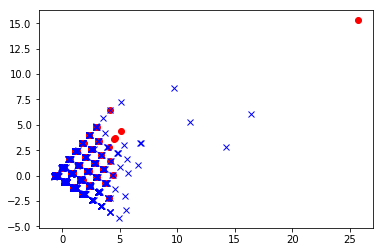

In [162]:
plt.plot(Am_X, Am_Y, 'ro', Non_X, Non_Y, 'bx')
#plt.show()
#plt.plot(Non_X, Non_Y, 'x')
plt.show()